# Homework #3 -- *you'll need to do this on google colab*

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***.
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified.
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on...

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains.

# Solution by Huiyang Chen
## Part 0

I have found this dataset about obesity in Kaggle, and here is the link to the dataset: https://www.kaggle.com/datasets/mrsimple07/obesity-prediction?resource=download

The dataset consists of 1000 individuals who are categorized as underweight, normal weight, overweight, and obese.

In [8]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/STA365')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Read dataset
df = pd.read_csv("obesity_data.csv")

In [10]:
# Take a quick look at data
df.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


From the above summary table of all variables, we can see that we have 5 numerical variables and the sample size is 1000. The key variable of interest here is BMI that stands for the body mass index, which is a measurement of obesity. The math formula of this index is given as:
$$ BMI = \frac{Weight}{(Height)^2} $$

With this dataset, we might construct models that explain the association between physical activity level and the level of obesity with control of age.

## Part 1
Let's first take a look at the key variable of interest, which can very likely be the response variable, the BMI. We can use a histogram to examine its distribution.

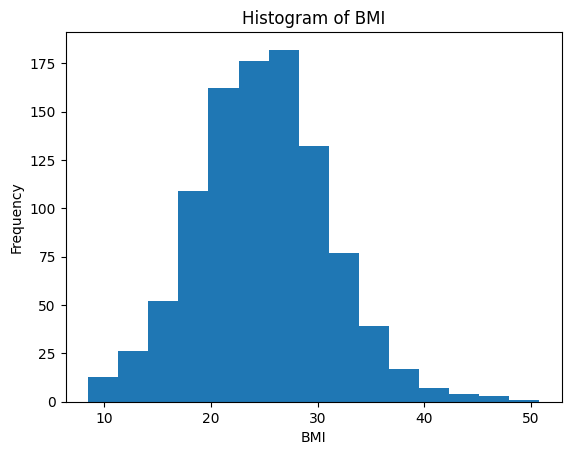

In [11]:
# Plot the histogram of BMI
plt.hist(df['BMI'], bins=15)  # Adjust the number of bins as needed
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI')
plt.show()

From the above histogram, we can see that the distribution of BMI is roughly normal but slightly right-skewed, with its mode in between 20 and 30. This motivates us to try construct posterior inference with a normal-gamma specification. Note that, in this context of an observational study with finite sample, we do not know the value of true precision, so we decide to specify posterior with normal-gamma rather than normal-normal.

Let's take a closer look at the normal-gamma specification. From the above histogram, we assume the posterior distribution of BMI is a normal distribution parametrized by a mean parameter $\theta$ and a precision parameter $\phi$.

$$\text{Posterior} = p(\theta, \phi | x)$$

Since we have two parameters to estimate, we set two priors, each for one parameter. The prior distribution of $\theta$ is a normal distribution parameterized by a mean parameter $\theta_0$ and a precision parameter $\tau$. The prior distribution of $\phi$ is a gamma distribution parameterized by a shape parameter $\alpha$ and a scale parameter $\beta$.

$$\text{Prior of } \theta = p(\theta | \theta_0, \tau) = \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau(\theta-\theta_0)^2}{2}}$$

$$\text{Prior of } \phi = p(\phi | \alpha, \beta) = \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \phi^{\alpha -1}e^{-\beta \phi}$$

Note that the none of the above priors have shared parameter, so we can say that $\theta$ is independent of $\phi$.

We select a normal likelihood for our observed data $x$ parametrized by $theta$, and $phi$, so we have the likelihood specified like this:

$$\text{Likelihood} = p(x | \theta, \phi) = \prod_{i=1}^n\sqrt{\frac{\phi}{2\pi}} e^{-\frac{\phi\left(x_i-\theta\right)^2}{2}}$$

Then we can derive the expression of the posterior:
$$p(\theta, \phi | x) \propto p(x, \theta, \phi) = p(x | \theta, \phi) p(\theta | \theta_0, \tau) p(\phi | \alpha, \beta) = [\prod_{i=1}^n\sqrt{\frac{\phi}{2\pi}} e^{-\frac{\phi(x_i-\theta)^2}{2}}] \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau(\theta-\theta_0)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \phi^{\alpha -1}e^{-\beta \phi}$$

### Selecting hyperparameters

According to some quick google search, the average BMI of American is 26.6, so I will choose $\theta_0 = 26.6$ and $\tau = 0.01$ picked arbitrarily.

I could not find information about the variance of BMI, so I used a weakly informative prior that looks quite flat in this case:
$\alpha = 1, \beta = 0.01$

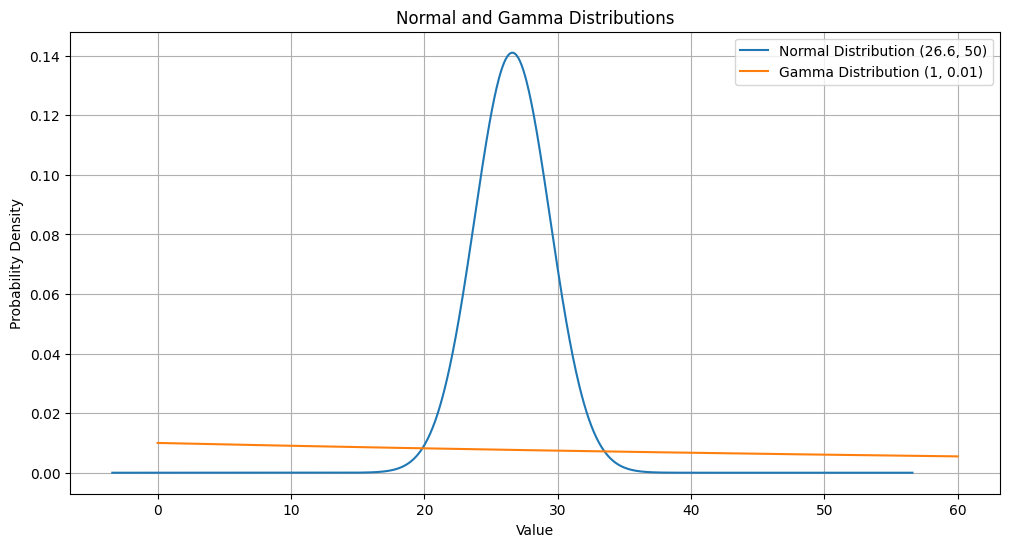

In [12]:
# Visualize priors
random.seed(365)
# Normal Distribution parameters
theta_0, sigma = 26.6, 10
tau = 1/(sigma^2)
# Gamma Distribution parameters
alpha, beta = 1, 0.01

# Generating points on the x axis
x_normal = np.linspace(theta_0 - 3*sigma, theta_0 + 3*sigma, 1000)
x_gamma = np.linspace(0, 60, 1000)  # Adjust the upper limit as needed

# PDFs for both distributions
pdf_normal = stats.norm.pdf(x_normal, theta_0, 1/tau**0.5)
pdf_gamma = stats.gamma.pdf(x_gamma, alpha, scale=1/beta)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_normal, pdf_normal, label='Normal Distribution (26.6, 50)')
plt.plot(x_gamma, pdf_gamma, label='Gamma Distribution (1, 0.01)')
plt.title('Normal and Gamma Distributions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

With the above distributions and hyperparameters specified, now we can conduct our posterior inference using PyMC.

In [13]:
import pymc as pm
# Set up the normal-gamma model as pre-specified
normal_gamma_BMI_model = pm.Model()
with normal_gamma_BMI_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5,
                      observed=df["BMI"])

In [14]:
# Conduct Hamiltonian MC Sampling
random.seed(365)
with normal_gamma_BMI_model:
    idata_HMC = pm.sample() # Can specify more chains here

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'theta': 0.9998, 'phi': 1.0003}


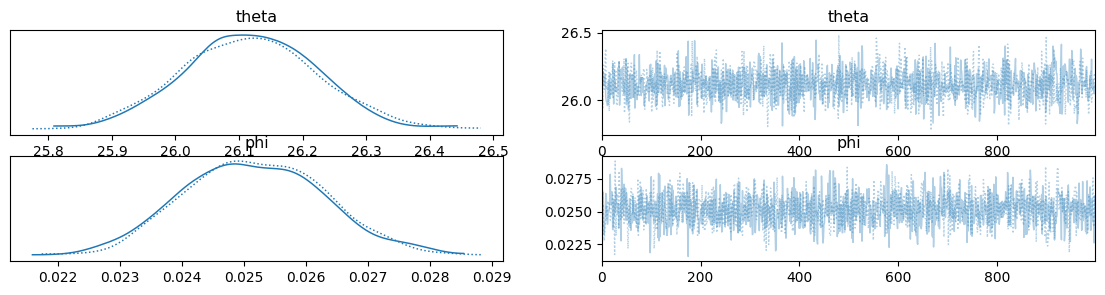

In [15]:
import arviz as az
# Sketch the trace plot
fig, ax = plt.subplots(2,2, figsize=(14,3))
# Default is 2 chains, fine for this homework
az.plot_trace(idata_HMC, axes = ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

From the above trace plots, we can see that the two chains for $\theta$ and $\phi$ roughly converge, so we do not have any convergence issue with our model.

In [16]:
# Generate summary statistics
print("Number of MCMC samples: ",
      idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

Number of MCMC samples:  2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,26.12,0.11,25.92,26.32,0.0,0.0,1946.46,1473.63,1.0
phi,0.03,0.00,0.02,0.03,0.0,0.0,1731.23,1392.53,1.0


The r hat reported for $\theta$ and $\phi$ are both 1.0, which are smaller than 1.1, so we have no convergence issue with our estimation of these parameters. The posterior mean for $\theta$ representing the true mean is 26.12, and the posterior mean for $\phi$ representing the true precision is 0.03. With total number of 2000 MCMC samples, the effective sample sizes for $\theta$ and $\phi$ are not too small compared to 2000, so the issue of autocorrelation is not evident.

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

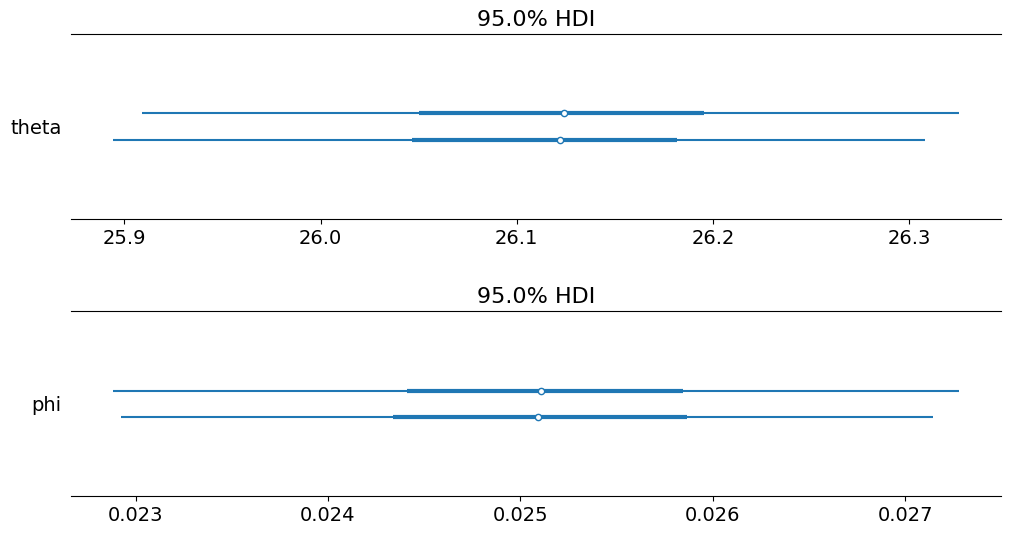

In [ ]:
# Sketch credible intervals
fig,ax = plt.subplots(2,1, figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95,
               ax=ax[0])
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95,
               ax=ax[1])

From the above credible intervals, we can say that, for chain 1, there is 95 percent of probability that the true $\theta$ (true average BMI) falls between roughly 25.91 and 26.33, and the true $\phi$ (precision) falls between 0.0228 and 0.0273.

## Part 2

Now let's find a variable that does not look normal, so a specification of normal-gamma is not justified.

Let's look at the distribution of variable age with a histogram.

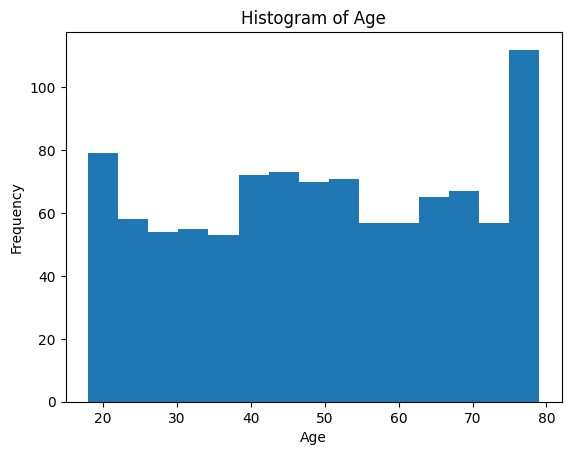

In [ ]:
# Plot the histogram of age
plt.hist(df['Age'], bins=15)  # Adjust the number of bins as needed
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

From the histogram of age, we can see that it is roughly uniformly distributed with a very high mode at the very right end. This distribution is definitely not normal, so a normal-gamma specification is not justified in this case.

## Part 3

I am going to make the assumption that the variable age is in fact uniformly distributed ($Age \sim Unif(a,b)$), and use the PyMC specification to make posterior inference on the upper and lower bounds ($a$ and $b$) of the uniform distribution.


Therefore, I will have a uniform likelihood, and I need to specify priors for the parameters $a$ and $b$. I am going to use weakly-informative priors, uniform distributions with the upper bound and lower bound selected arbitrarily. The reason to do so is that I have to make sure the support of my priors aligns with my likelihood, and that I do not have strong prior knowledge on the upper and lower bounds.


$$\text{Prior of } a = p(\theta | a_0, b_0) = \frac{1}{b_0-a_0}$$

$$\text{Prior of } b = p(\theta | a_1, b_1) = \frac{1}{b_1-a_1}$$


$$\text{Likelihood} = p(x | a, b) = \prod_{i=1}\frac{1}{b-a} = \frac{1}{(b-a)^n}$$

Then we can derive the expression of the posterior:
$$p(a, b | x) \propto p(x, a, b) = p(x | a, b) p(a | a_0, b_0) p(b | a_1, b_1) = \frac{1}{(b-a)^n}\frac{1}{b_0-a_0}\frac{1}{b_1-a_1}$$

I will specify the hyperparameters to be:
$(a_0, b_0) = (0, 50), (a_1, b_1) = (50, 100)$, since it would make sense for a human to have an age between 0 and 100, and I have to ensure $b > a$ for my likelihood to function. Besides that, I do not have much prior information on the distribution of age to begin with.

In [64]:
# Find out the upper and lower bounds in the data
print(max(df["Age"]), min(df["Age"]))

79 18


In [70]:
# Set up the uniform-uniform model as pre-specified
a0 = 0; a1 = 50; b0 = 50; b1 = 100
min = 18; max = 79
uniform_age_model = pm.Model()
with uniform_age_model:
    a = pm.Uniform("a", lower=a0, upper=b0)
    b = pm.Uniform("b", lower=a1, upper=b1)
    x_obs = pm.Uniform("likelihood", lower=min, upper=max,
                      observed=df["Age"])

In [71]:
# Conduct Hamiltonian MC Sampling
random.seed(365)
with uniform_age_model:
    idata_HMC_age = pm.sample() # Can specify more chains here

## Part 4

Now let's conduct posterior inference for the upper and lower bounds of this uniform distribution.

HMC Split-Rhats {'a': 1.0004, 'b': 1.0002}


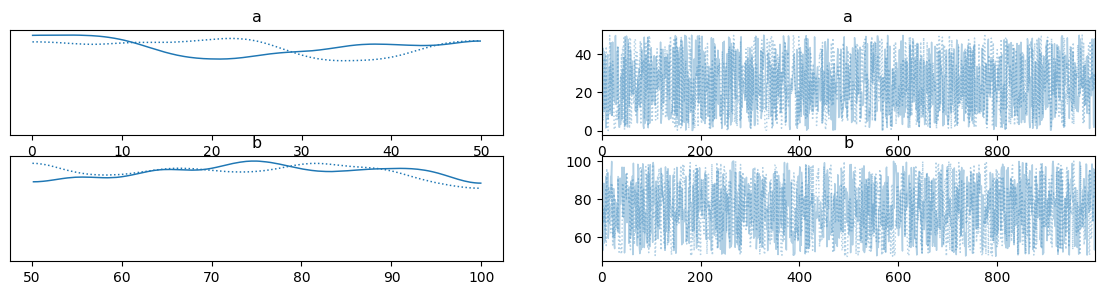

In [72]:
# Sketch the trace plot
fig, ax = plt.subplots(2,2, figsize=(14,3))
# Default is 2 chains, fine for this homework
az.plot_trace(idata_HMC_age, axes = ax[:2,:2])
print("HMC Split-Rhats",
 {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC_age).items()})

From the above trace plots, we can see that the two chains for $\theta$ and $\phi$ roughly converge, so we do not have any obvious convergence issue with our model.

In [74]:
# Generate summary statistics
print("Number of MCMC samples: ",
      idata_HMC_age.posterior['a'].values.flatten().shape[-1])
az.summary(idata_HMC_age, round_to=2)

Number of MCMC samples:  2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,24.55,14.74,1.06,48.18,0.33,0.24,1778.15,1302.56,1.0
b,74.88,14.04,50.85,96.83,0.33,0.24,1573.42,1121.51,1.0


The r hat reported for $a$ and $b$ are both 1.0, which are smaller than 1.1, so we have no convergence issue with our estimation of these parameters. The posterior mean for $a$ representing the true lower bound for the true uniform distribution of age is 24.55, and the posterior mean for $b$ representing the true upper bound is 74.88. With total number of 2000 MCMC samples, the effective sample sizes for $\theta$ and $\phi$ are not too small compared to 2000, so the issue of autocorrelation is not evident.

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

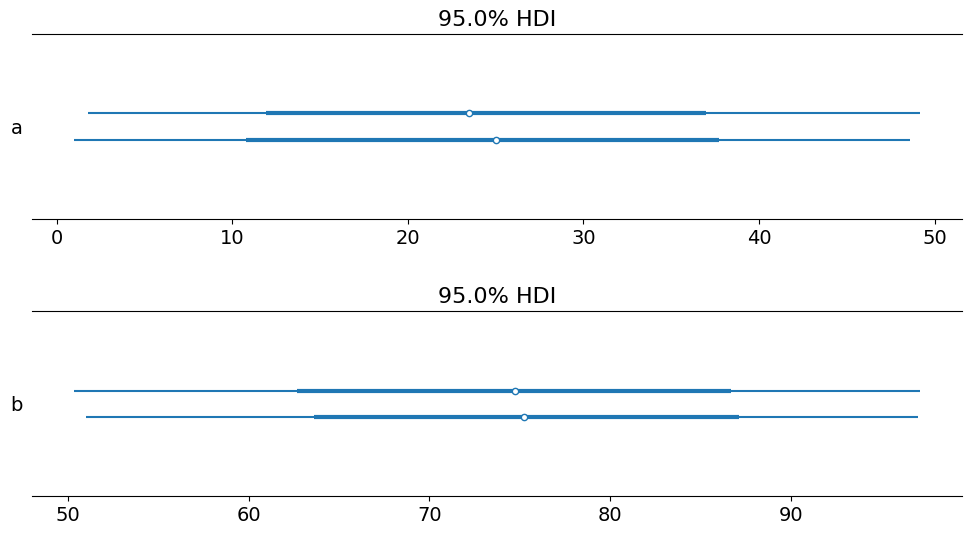

In [76]:
# Sketch credible intervals
fig,ax = plt.subplots(2,1, figsize=(12,6))
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata_HMC_age, var_names=["a"], combined=False, hdi_prob=0.95,
               ax=ax[0])
az.plot_forest(idata_HMC_age, var_names=["b"], combined=False, hdi_prob=0.95,
               ax=ax[1])

From the above credible intervals, we can say that, for chain 1, there is 95 percent of probability that the true $a$ (true lower bound for age) falls between roughly 2 and 49, and the true $\phi$ (true upper bound for age) falls between 51 and 98.